In [1]:
%matplotlib inline
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas
from matplotlib import ticker
from matplotlib.gridspec import GridSpec

from plot import bootstrap_samples_mean

plt.style.use('seaborn')
plt.style.use('seaborn-paper')
plt.style.use('tableau-colorblind10')
plt.rcParams.update({
    'figure.figsize': (3.6, 4),
    'text.usetex': True,
    'legend.borderpad': 0,
    'xtick.bottom': True,
    'xtick.major.size': 2,
    'xtick.minor.size': 1,
    'lines.markersize': 3,
    'lines.linewidth': 0.8,
    'errorbar.capsize': 0,
    'lines.markeredgewidth': 0.8
})

In [2]:
sample_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

In [3]:
uinds = []
tinds = []
nind_ngs = []
nind_gs = []
for s in sample_sizes:
    run_id = f'wave_{s}_202205{19 if s <= 500 else 20}'
    zip = zipfile.ZipFile(f'../results/{run_id}.zip')

    uind = pandas.read_csv(zip.open(f'{run_id}/uind.csv'))
    uind['sample_size'] = s
    uinds.append(uind)

    tind = pandas.read_csv(zip.open(f'{run_id}/bootstrap.csv'))
    tind['sample_size'] = s
    tinds.append(tind)

    nind_ng = pandas.read_csv(zip.open(f'{run_id}/findg_0.05_1.00_1.csv'))
    nind_ng['sample_size'] = s
    nind_ngs.append(nind_ng)

    nind_g = pandas.read_csv(zip.open(f'{run_id}/findg_0.05_1.00_1.csv'))
    nind_g['sample_size'] = s
    nind_gs.append(nind_g)

In [4]:
uind = pandas.concat(uinds)
tind = pandas.concat(tinds)
nind_ng = pandas.concat(nind_ngs)
nind_g = pandas.concat(nind_gs)

In [5]:
nind_ng_timeouts = nind_ng[nind_ng['timeout']].groupby('sample_size').size()
nind_ng_timeouts /= nind_ng.groupby('sample_size').size()

In [6]:
nind_g_timeouts = nind_g[nind_g['timeout']].groupby('sample_size').size()
nind_g_timeouts /= nind_g.groupby('sample_size').size()

In [7]:
def compute_mean_err(index: np.ndarray, df: pandas.DataFrame, col: str, default: float = 0.):
    mean = np.full(len(index), default)
    err = np.zeros_like(mean)
    for i, c in enumerate(index):
        rows = df[df['sample_size'] == c]
        if len(rows):
            samples = bootstrap_samples_mean(rows[col])
            mean[i], err[i] = np.mean(samples), np.std(samples)
    return mean, err

In [8]:
uind_mean, uind_err = compute_mean_err(sample_sizes, uind, 'time')
tind_mean, tind_err = compute_mean_err(sample_sizes, tind, 'time')
nind_ng_mean, nind_ng_err = compute_mean_err(sample_sizes, nind_ng[~nind_ng['timeout']], 'time', 3000)
nind_g_mean, nind_g_err = compute_mean_err(sample_sizes, nind_g[~nind_g['timeout']], 'time', 3000)

In [9]:
uind_accepted_mean, uind_accepted_err = compute_mean_err(sample_sizes, uind, 'uinds')
tind_accepted_mean, tind_accepted_err = compute_mean_err(sample_sizes, tind, 'accepted')
nind_ng_accepted_mean, nind_ng_accepted_err = compute_mean_err(sample_sizes, nind_ng[~nind_ng['timeout']], 'unique_ind')
nind_g_accepted_mean, nind_g_accepted_err = compute_mean_err(sample_sizes, nind_g[~nind_g['timeout']], 'unique_ind')

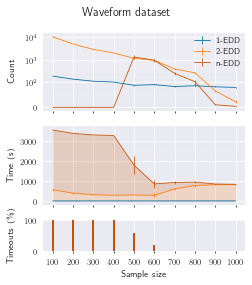

In [11]:
sampling_color = '#555555'
sampling_bg = '#ccccd3'
uind_color = '#006ba4'
uind_bg = '#bbd0e2'
tind_color = '#ff800e'
tind_bg = '#eed4c4'
nind_g_color = '#ababab'
nind_g_bg = '#dddde4'
nind_ng_color = '#c85200'
nind_ng_bg = '#d8c4bd'

fig = plt.figure()

gs = GridSpec(nrows=5, ncols=1)

# Counts
ax_counts = fig.add_subplot(gs[0:2, 0])
ax_counts.errorbar(sample_sizes, uind_accepted_mean, yerr=uind_accepted_err, label='1-EDD',
                   color=uind_color)
ax_counts.errorbar(sample_sizes, tind_accepted_mean, yerr=tind_accepted_err, label='2-EDD',
                   color=tind_color)
ax_counts.errorbar(sample_sizes, nind_ng_accepted_mean, yerr=nind_ng_accepted_err,
                   label='n-EDD', color=nind_ng_color)

ax_counts.set_yscale('symlog', linthresh=100)
ax_counts.legend()
ax_counts.set_ylabel('Count')
ax_counts.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax_counts.yaxis.grid(True, which='minor', linewidth=0.1)

plt.setp(ax_counts.get_xticklabels(), visible=False)

# Time
ax_time = fig.add_subplot(gs[2:4, 0], sharex=ax_counts)

ax_time.errorbar(sample_sizes, uind_mean, yerr=uind_err, label='1-EDD time', color=uind_color)
ax_time.fill_between(sample_sizes, uind_mean, color=uind_color, alpha=0.2)

ax_time.errorbar(sample_sizes, uind_mean + tind_mean, yerr=tind_err, label='+ 2-EDD', color=tind_color)
ax_time.fill_between(sample_sizes, uind_mean, uind_mean + tind_mean, color=tind_color, alpha=0.2)

ax_time.errorbar(sample_sizes, uind_mean + tind_mean + nind_ng_mean, yerr=nind_ng_err, label='+ n-EDD time',
                 color=nind_ng_color)
ax_time.fill_between(sample_sizes, uind_mean + tind_mean, uind_mean + tind_mean + nind_ng_mean, color=nind_ng_color, alpha=0.2)

#ax_time.errorbar(sample_sizes, uind_mean + tind_mean + nind_g_mean, yerr=nind_g_err, label='+ n-EDD time (grow)',
#                 color=nind_g_color)
#ax_time.fill_between(sample_sizes, uind_mean + tind_mean, uind_mean + tind_mean + nind_g_mean, color=nind_g_bg, zorder=1)

#ax_time.legend(loc='upper left')
ax_time.set_ylabel('Time (s)')

ax_time.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax_time.yaxis.grid(True, which='minor', linewidth=0.1)

plt.setp(ax_time.get_xticklabels(), visible=False)

ax_timeouts = fig.add_subplot(gs[4, 0], sharex=ax_counts)
#ax_timeouts.bar(nind_g_timeouts.index-0.15, nind_g_timeouts * 100, width=10, color=nind_g_color, label='Growing stage')
ax_timeouts.bar(nind_ng_timeouts.index, nind_ng_timeouts * 100, width=10, color=nind_ng_color, label='No growing stage')
#ax_timeouts.legend()

ax_timeouts.set_ylabel('Timeouts (\%)')
ax_timeouts.set_xlabel('Sample size')
ax_timeouts.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax_timeouts.yaxis.grid(True, which='minor', linewidth=0.1)
ax_timeouts.set_ylim(0, 100)
ax_timeouts.set_xticks(sample_sizes)

plt.suptitle('Waveform dataset')

fig.align_ylabels([ax_counts, ax_time, ax_timeouts])

plt.tight_layout()
plt.savefig('/home/aalvarez/Downloads/scalability_sample_wave.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()